In [18]:
import pandas as pd
import numpy as np
import glob
import os
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [5]:
# Path to directory with spectral data
directory_path = 'spectral data corrected/2024/'

# Find matching name files
csv_files = glob.glob(os.path.join(directory_path, 'tc_2024-08-*_full_day.csv'))

# Loading CSVs into list of DataFrames
df_list = [pd.read_csv(file) for file in csv_files]

# Combine all df's into a single DataFrame
df_combined = pd.concat(df_list, ignore_index=True)

# Show the first few rows
df_combined.head()

,dt_UTC01_NoDLS,300.0,301.0,302.0,303.0,304.0,305.0,306.0,307.0,308.0,...,1091.0,1092.0,1093.0,1094.0,1095.0,1096.0,1097.0,1098.0,1099.0,1100.0
0,2024-08-01 04:00:00,-0.02,-0.03,-0.04,-0.03,-0.02,-0.05,-0.01,-0.03,-0.02,...,0.34,0.34,0.17,0.14,0.19,1.03,0.68,0.37,1.19,0.72
1,2024-08-01 04:01:00,-0.00,-0.02,-0.00,0.00,-0.03,-0.01,-0.00,-0.00,0.01,...,0.65,-0.22,0.88,0.67,0.03,0.24,-0.78,0.18,0.82,-0.19
2,2024-08-01 04:02:00,-0.00,0.00,-0.02,-0.01,0.01,-0.00,-0.00,-0.01,-0.02,...,-0.35,-0.16,-0.05,-0.75,-0.03,0.22,0.62,0.40,-1.04,-0.05
3,2024-08-01 04:03:00,-0.00,0.01,0.00,-0.02,0.02,0.00,-0.01,0.01,0.01,...,-0.10,0.52,-1.31,-1.37,-0.50,-0.49,-0.56,-1.38,0.16,1.77
4,2024-08-01 04:04:00,-0.04,-0.05,-0.02,-0.04,-0.04,-0.02,-0.01,-0.01,0.02,...,-0.43,0.57,0.13,-0.33,-0.81,-0.57,0.26,-0.49,-0.28,-0.43


In [6]:
print(df_combined.columns.tolist())

['dt_UTC01_NoDLS', '300.0', '301.0', '302.0', '303.0', '304.0', '305.0', '306.0', '307.0', '308.0', '309.0', '310.0', '311.0', '312.0', '313.0', '314.0', '315.0', '316.0', '317.0', '318.0', '319.0', '320.0', '321.0', '322.0', '323.0', '324.0', '325.0', '326.0', '327.0', '328.0', '329.0', '330.0', '331.0', '332.0', '333.0', '334.0', '335.0', '336.0', '337.0', '338.0', '339.0', '340.0', '341.0', '342.0', '343.0', '344.0', '345.0', '346.0', '347.0', '348.0', '349.0', '350.0', '351.0', '352.0', '353.0', '354.0', '355.0', '356.0', '357.0', '358.0', '359.0', '360.0', '361.0', '362.0', '363.0', '364.0', '365.0', '366.0', '367.0', '368.0', '369.0', '370.0', '371.0', '372.0', '373.0', '374.0', '375.0', '376.0', '377.0', '378.0', '379.0', '380.0', '381.0', '382.0', '383.0', '384.0', '385.0', '386.0', '387.0', '388.0', '389.0', '390.0', '391.0', '392.0', '393.0', '394.0', '395.0', '396.0', '397.0', '398.0', '399.0', '400.0', '401.0', '402.0', '403.0', '404.0', '405.0', '406.0', '407.0', '408.0', 

In [7]:
print(df_combined.index.name)

None


In [8]:
df_combined.set_index('dt_UTC01_NoDLS', inplace=True)

df_combined.shape

(33411, 801)

In [9]:
df_combined = df_combined.apply(pd.to_numeric, errors='coerce')
spectra = df_combined.dropna(axis=1, how='any')
print(spectra.dtypes)

300.0     float64
301.0     float64
302.0     float64
303.0     float64
304.0     float64
           ...   
1096.0    float64
1097.0    float64
1098.0    float64
1099.0    float64
1100.0    float64
Length: 801, dtype: object


In [61]:
ambient_temp = pd.read_csv('weather data/T_ambient_2024_08.csv')
precipitation = pd.read_csv('weather data/Precipitation_2024_08.csv')
wind_speed = pd.read_csv('weather data/Wind_Speed_2024_08.csv')
ambient_temp.head()

,Time,T_amb_avg,RH_avg,T_KNMI
0,2024-08-01 00:00:00,20.9,85.9,18.7
1,2024-08-01 00:01:00,20.8,86.3,NaN
2,2024-08-01 00:02:00,20.8,86.5,NaN
3,2024-08-01 00:03:00,20.8,86.7,NaN
4,2024-08-01 00:04:00,20.8,86.7,NaN


In [63]:
print(ambient_temp.columns)
print(precipitation.columns)
print(wind_speed.columns)

Index(['Time', 'T_amb_avg', 'RH_avg', 'T_KNMI'], dtype='object')
Index(['Time', 'pr_int'], dtype='object')
Index(['Time', 'v_avg', 'windstoot/gust(v_max)', 'v_min'], dtype='object')


In [64]:
# Parse 'Time' column to datetime
ambient_temp["Time"] = pd.to_datetime(ambient_temp["Time"])
precipitation["Time"] = pd.to_datetime(precipitation["Time"])
wind_speed["Time"] = pd.to_datetime(wind_speed["Time"])

# Filter: keep times between 04:00 and 22:00 across all dates
df_filtered_temp = ambient_temp[(ambient_temp["Time"].dt.hour >= 4) & (ambient_temp["Time"].dt.hour < 22)].copy()
df_filtered_precipitation =precipitation[(precipitation["Time"].dt.hour >= 4) & (precipitation["Time"].dt.hour < 22)].copy()
df_filtered_wind =wind_speed[(wind_speed["Time"].dt.hour >= 4) & (wind_speed["Time"].dt.hour < 22)].copy()

# (Optional) Save or inspect
# df_filtered.to_csv("filtered_june_4to22.csv", index=False)

In [65]:
print("Ambient size after filtering:", df_filtered_temp.shape)
print("Precipitation size after filtering:", df_filtered_precipitation.shape)
print("Wind speed size after filtering:", df_filtered_wind.shape)
print("Irradiance size:", spectra.shape)

Ambient size after filtering: (33480, 4)
Precipitation size after filtering: (33480, 2)
Wind speed size after filtering: (33480, 4)
Irradiance size: (33411, 801)


In [72]:
# Keep 'Time' only from the temperature dataframe (for example)
temp_df = df_filtered_temp.copy()
wind_df = df_filtered_wind.drop(columns=['Time'])
precip_df = df_filtered_precipitation.drop(columns=['Time'])

# Combined
df_weather_data = pd.concat([temp_df, wind_df, precip_df], axis=1)

df_weather_data.shape

(33480, 8)

In [73]:
# 1. Make sure datetime formats match
df_weather_data["Time"] = pd.to_datetime(df_weather_data["Time"])
spectra.index = pd.to_datetime(spectra.index)

# 2. Compute exact common timestamps
common_times = df_weather_data["Time"].unique()
common_times = np.intersect1d(common_times, spectra.index)

# 3. Filter both datasets to the common timestamps
df_weather_synced = df_weather_data[df_weather_data["Time"].isin(common_times)]
df_irradiance_synced = spectra[spectra.index.isin(common_times)]

# Step 5: Verify size match
print("Ambient size after filtering:", df_weather_synced.shape)
print("Irradiance size:", df_irradiance_synced.shape)

Ambient size after filtering: (33376, 8)
Irradiance size: (33376, 801)


In [15]:
data_tensor = torch.tensor(df_irradiance_synced.values, dtype=torch.float32)
data_tensor

tensor([[-0.0200, -0.0300, -0.0400,  ...,  0.3700,  1.1900,  0.7200],
        [-0.0000, -0.0200, -0.0000,  ...,  0.1800,  0.8200, -0.1900],
        [-0.0000,  0.0000, -0.0200,  ...,  0.4000, -1.0400, -0.0500],
        ...,
        [-0.0100, -0.0100, -0.0000,  ..., -0.7900,  0.0700, -0.1700],
        [ 0.0300,  0.0200,  0.0100,  ...,  0.8600, -0.9300,  0.7100],
        [-0.0300, -0.0300, -0.0100,  ...,  0.7000,  0.4200,  0.6000]])

In [16]:
print("Tensor shape:", data_tensor.shape)  # (N, 801), where N is the number of time stamps

Tensor shape: torch.Size([33376, 801])


In [19]:
# Min-max normalization
min_vals = data_tensor.min(dim=1, keepdim=True).values
max_vals = data_tensor.max(dim=1, keepdim=True).values

# Avoid divide-by-zero by adding a small epsilon
normalized_tensor = (data_tensor) / (max_vals + 1e-8)


# Wrap data into a TensorDataset and DataLoader
dataset = TensorDataset(normalized_tensor)
dataloader = DataLoader(dataset, batch_size=60, shuffle=True)

In [20]:
max_vals.shape

torch.Size([33376, 1])

In [21]:

class DAE(nn.Module):
    def __init__(self):
        super(DAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(801, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 6)
        )

        self.decoder = nn.Sequential(
            nn.Linear(6, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 801)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [22]:
net = DAE()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [23]:
criterion = nn.MSELoss
optimizer = torch.optim.AdamW(net.parameters(), lr=0.0001)

In [24]:
# Move model to device
net = net.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3)

# Training loop
n_epochs = 300
net.train()

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for batch in dataloader:
        inputs = batch[0].to(device)

        # Forward pass
        outputs = net(inputs)

        # Compute loss
        loss = criterion(outputs, inputs)  # Reconstruction loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)  # Weighted sum

    avg_loss = epoch_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.6f}")


Epoch [1/300], Loss: 0.009492
Epoch [2/300], Loss: 0.003464
Epoch [3/300], Loss: 0.003229
Epoch [4/300], Loss: 0.003001
Epoch [5/300], Loss: 0.002816
Epoch [6/300], Loss: 0.002669
Epoch [7/300], Loss: 0.002624
Epoch [8/300], Loss: 0.002589
Epoch [9/300], Loss: 0.002567
Epoch [10/300], Loss: 0.002538
Epoch [11/300], Loss: 0.002521
Epoch [12/300], Loss: 0.002503
Epoch [13/300], Loss: 0.002543
Epoch [14/300], Loss: 0.002451
Epoch [15/300], Loss: 0.002444
Epoch [16/300], Loss: 0.002421
Epoch [17/300], Loss: 0.002417
Epoch [18/300], Loss: 0.002429
Epoch [19/300], Loss: 0.002388
Epoch [20/300], Loss: 0.002371
Epoch [21/300], Loss: 0.002393
Epoch [22/300], Loss: 0.002355
Epoch [23/300], Loss: 0.002364
Epoch [24/300], Loss: 0.002352
Epoch [25/300], Loss: 0.002312
Epoch [26/300], Loss: 0.002335
Epoch [27/300], Loss: 0.002328
Epoch [28/300], Loss: 0.002312
Epoch [29/300], Loss: 0.002288
Epoch [30/300], Loss: 0.002292
Epoch [31/300], Loss: 0.002272
Epoch [32/300], Loss: 0.002266
Epoch [33/300], L

In [25]:
net.eval()

# Move normalized input to device
with torch.no_grad():
    latent_representations = net.encoder(normalized_tensor.to(device))

# Move to CPU and convert to numpy if needed
latent_representations = latent_representations.cpu()

print("Latent shape:", latent_representations.shape)  # Should be (60, 6)
print("Device", latent_representations.device)

Latent shape: torch.Size([33376, 6])
Device cpu


In [26]:
# Convert to numpy if not already
latent_np = latent_representations.numpy()


In [27]:


# Convert to numpy if not already
# latent_np = latent_representations.numpy()
#
# # Optional: dendrogram visualization (just for fun)
# linked = linkage(latent_np, method='ward')
# plt.figure(figsize=(10, 4))
# # dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
# dendrogram(linked,
#            orientation='top',
#            distance_sort='descending',
#            show_leaf_counts=True,
#            labels=np.arange(len(latent_np)))
#
# plt.title("Dendrogram (HAC)")
# plt.xlabel("Sample index")
# plt.ylabel("Distance")
# plt.tight_layout()
# plt.show()

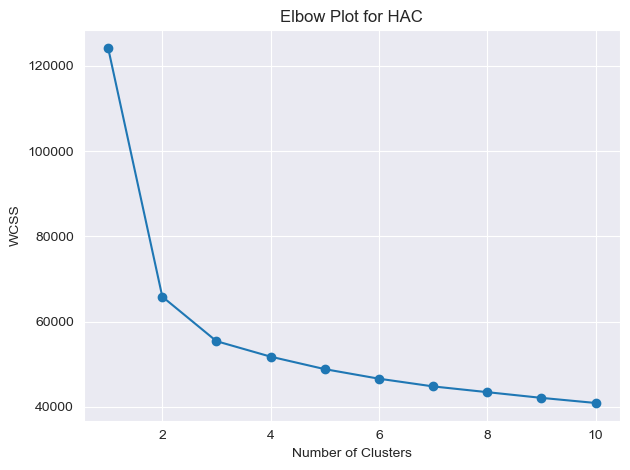

In [28]:

wcss = []
cluster_range = range(1, 11)

for k in cluster_range:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(latent_np)

    # Compute WCSS manually
    wcss_k = 0
    for cluster_id in np.unique(labels):
        cluster_points = latent_np[labels == cluster_id]
        centroid = cluster_points.mean(axis=0)
        distances = np.sum((cluster_points - centroid) ** 2)
        wcss_k += distances

    wcss.append(wcss_k)

# Plot WCSS (elbow)
plt.figure()
plt.plot(cluster_range, wcss, marker='o')
plt.title("Elbow Plot for HAC")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:


# HAC with 5 clusters
hac_5 = AgglomerativeClustering(n_clusters=5)
cluster_labels = hac_5.fit_predict(latent_np)

In [30]:
cluster_labels.shape

(33376,)

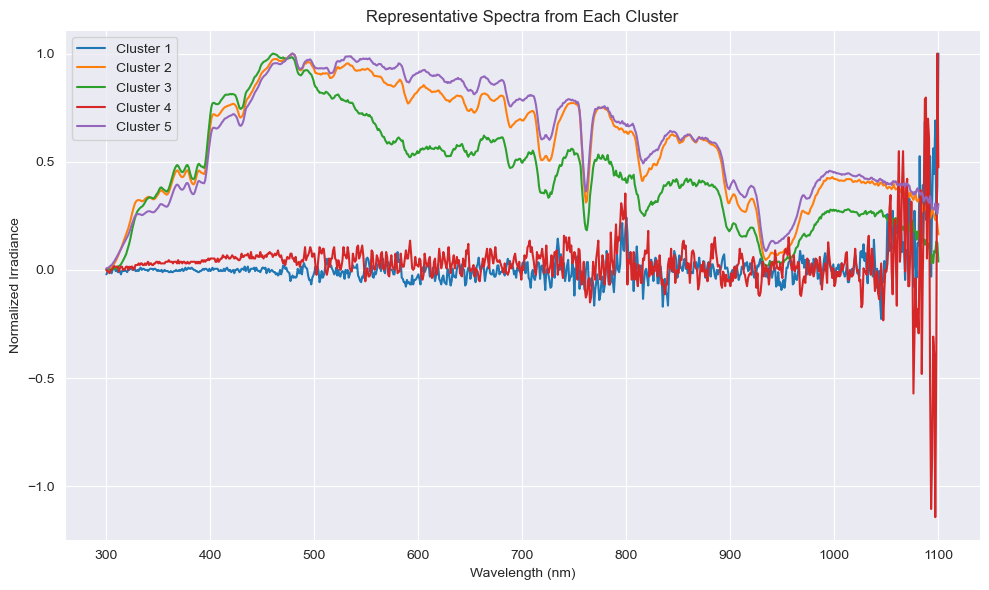

In [31]:

representative_indices = []

for cluster_id in np.unique(cluster_labels):
    # Step 1: Get indices of samples in this cluster
    cluster_idx = np.where(cluster_labels == cluster_id)[0]
    cluster_latents = latent_np[cluster_idx]

    # Step 2: Compute pairwise distances within the cluster
    pairwise_dists = cdist(cluster_latents, cluster_latents, metric='euclidean')

    # Step 3: Sum distances for each sample
    sum_dists = pairwise_dists.sum(axis=1)

    # Step 4: Select index with minimum total distance
    rep_idx_within_cluster = np.argmin(sum_dists)
    rep_idx = cluster_idx[rep_idx_within_cluster]
    representative_indices.append(rep_idx)

# Step 5: Get the corresponding original spectra (denormalized if needed)
rep_spectra = normalized_tensor[representative_indices].cpu().numpy()

# Step 6: Plot the representative spectra
plt.figure(figsize=(10, 6))
#wavelengths = spectra['Wavelength'].values  # original x-axis
wavelengths = np.arange(300, 1101)

for i, spec in enumerate(rep_spectra):
    plt.plot(wavelengths, spec, label=f'Cluster {i+1}')

plt.title('Representative Spectra from Each Cluster')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Irradiance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
latent_np

array([[ 1.38695610e+00,  1.01225412e+00,  1.99750215e-01,
         3.31245631e-01, -7.97868371e-01,  3.06156904e-01],
       [-6.91738069e-01, -8.02123547e-01,  5.05745411e-04,
        -2.15434775e-01, -1.03543019e+00,  1.19674504e-01],
       [ 3.26243687e+00, -1.23986888e+00,  3.66242290e-01,
        -5.15941739e-01, -1.55467844e+00, -2.50558567e+00],
       ...,
       [ 2.46864486e+00,  1.64932072e+00,  4.04662549e-01,
        -1.35252321e+00,  1.13579881e+00,  1.97046757e-01],
       [ 6.31793797e-01, -2.29430720e-01, -5.03564656e-01,
         5.02533317e-01, -1.14329708e+00, -1.17865205e-01],
       [ 6.95929229e-01,  5.92874765e-01,  6.00693345e-01,
         1.85786467e-03, -7.11516678e-01, -4.33619648e-01]], dtype=float32)

In [34]:
# Use the existing DataFrame with timestamp index
wavelengths = df_irradiance_synced.columns.astype(float)  # convert column names (wavelengths) to float

# Calculate broadband irradiance per row (timestamp)
broadband_irradiance = np.trapz(df_irradiance_synced.values, x=wavelengths, axis=1)

# Add result as a new column
df_irradiance_synced["broadband_irradiance"] = broadband_irradiance
df_irradiance_synced.head()

C:\Users\20202351\AppData\Local\Temp\ipykernel_5308\2990846471.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_irradiance_synced["broadband_irradiance"] = broadband_irradiance


,300.0,301.0,302.0,303.0,304.0,305.0,306.0,307.0,308.0,309.0,...,1092.0,1093.0,1094.0,1095.0,1096.0,1097.0,1098.0,1099.0,1100.0,broadband_irradiance
dt_UTC01_NoDLS,,,,,,,,,,,,,,,,,,,,,
2024-08-01 04:00:00,-0.02,-0.03,-0.04,-0.03,-0.02,-0.05,-0.01,-0.03,-0.02,-0.02,...,0.34,0.17,0.14,0.19,1.03,0.68,0.37,1.19,0.72,-21.390
2024-08-01 04:01:00,-0.00,-0.02,-0.00,0.00,-0.03,-0.01,-0.00,-0.00,0.01,-0.00,...,-0.22,0.88,0.67,0.03,0.24,-0.78,0.18,0.82,-0.19,14.345
2024-08-01 04:02:00,-0.00,0.00,-0.02,-0.01,0.01,-0.00,-0.00,-0.01,-0.02,0.02,...,-0.16,-0.05,-0.75,-0.03,0.22,0.62,0.40,-1.04,-0.05,-9.905
2024-08-01 04:03:00,-0.00,0.01,0.00,-0.02,0.02,0.00,-0.01,0.01,0.01,-0.00,...,0.52,-1.31,-1.37,-0.50,-0.49,-0.56,-1.38,0.16,1.77,12.095
2024-08-01 04:04:00,-0.04,-0.05,-0.02,-0.04,-0.04,-0.02,-0.01,-0.01,0.02,-0.01,...,0.57,0.13,-0.33,-0.81,-0.57,0.26,-0.49,-0.28,-0.43,-29.455


In [74]:
# Step 5: Verify size match
print("Ambient size after filtering:", df_weather_synced.shape)
print("Irradiance size:", df_irradiance_synced.shape)

Ambient size after filtering: (33376, 8)
Irradiance size: (33376, 801)


In [76]:
df_weather_synced.head()

,Time,T_amb_avg,RH_avg,T_KNMI,v_avg,windstoot/gust(v_max),v_min,pr_int
240,2024-08-01 04:00:00,19.0,89.7,19.1,1.0,1.5,0.0,0.0
241,2024-08-01 04:01:00,19.0,89.7,NaN,0.8,1.9,0.0,0.0
242,2024-08-01 04:02:00,19.0,89.7,NaN,0.8,1.7,0.0,0.0
243,2024-08-01 04:03:00,19.0,89.8,NaN,0.8,2.5,0.0,0.0
244,2024-08-01 04:04:00,18.9,89.8,NaN,0.5,1.1,0.0,0.0


In [78]:
# Extract relevant data
temperature = df_weather_synced.iloc[:, 1]
wind_avg = df_weather_synced.iloc[:, 4]
precipitation_avg = df_weather_synced.iloc[:, 7]
broadband_irradiance = df_irradiance_synced.iloc[:, -1]


#Create a combined DataFrame for easier plotting
plot_df = pd.DataFrame({
    'Temperature': np.array(temperature),
    'Wind Avg': np.array(wind_avg),
    'Precipitation Avg': np.array(precipitation_avg),
    'Broadband Irradiance': np.array(broadband_irradiance),
    'Cluster': np.array(cluster_labels)
})
print("Temperature size:", temperature.shape)
print("Irradiance size:", broadband_irradiance.shape)
print("Cluster label size:", cluster_labels.shape)

Temperature size: (33376,)
Irradiance size: (33376,)
Cluster label size: (33376,)


In [79]:
plot_df

,Temperature,Wind Avg,Precipitation Avg,Broadband Irradiance,Cluster
0,19.0,1.0,0.0,0.72,0
1,19.0,0.8,0.0,-0.19,0
2,19.0,0.8,0.0,-0.05,3
3,19.0,0.8,0.0,1.77,0
4,18.9,0.5,0.0,-0.43,3
...,...,...,...,...,...
33371,19.5,1.2,0.0,-0.87,0
33372,19.5,2.0,0.0,0.43,0
33373,19.5,1.3,0.0,-0.17,0
33374,19.4,0.8,0.0,0.71,0


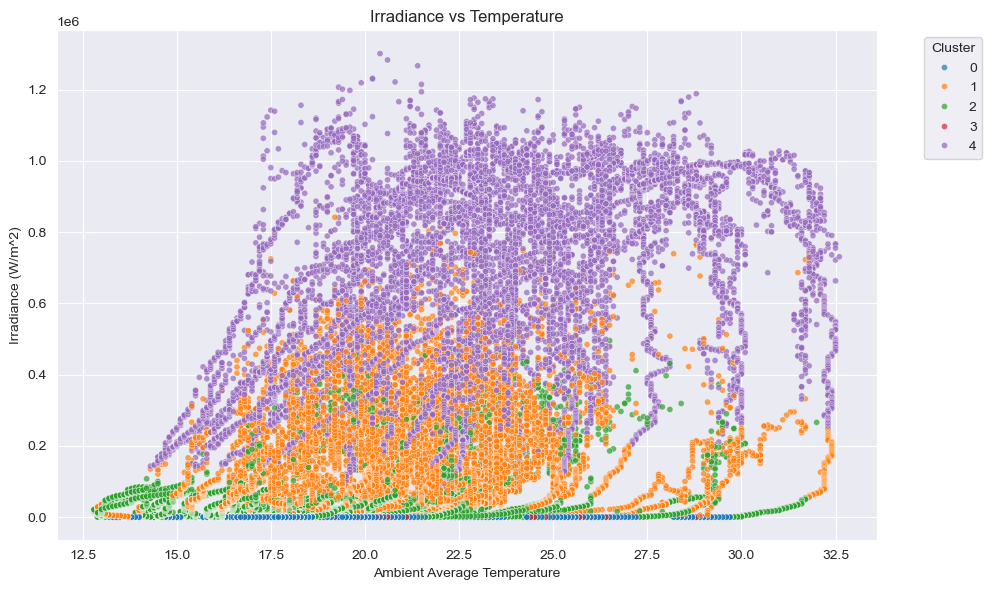

In [60]:
import seaborn as sns
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=plot_df,
    x='Temperature',
    y='Broadband Irradiance',
    hue='Cluster',
    palette='tab10',   # or 'Set2', 'viridis', etc.
    s=20,              # size of points
    alpha=0.7          # transparency
)

plt.title("Irradiance vs Temperature")
plt.xlabel("Ambient Average Temperature")
plt.ylabel("Irradiance (W/m^2)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

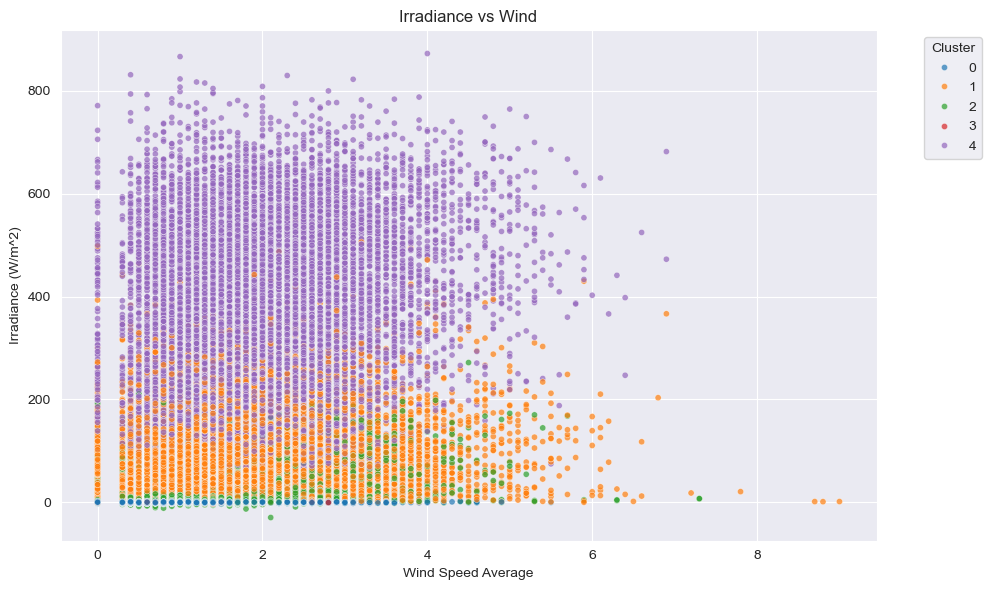

In [80]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=plot_df,
    x='Wind Avg',
    y='Broadband Irradiance',
    hue='Cluster',
    palette='tab10',   # or 'Set2', 'viridis', etc.
    s=20,              # size of points
    alpha=0.7          # transparency
)

plt.title("Irradiance vs Wind")
plt.xlabel("Wind Speed Average")
plt.ylabel("Irradiance (W/m^2)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

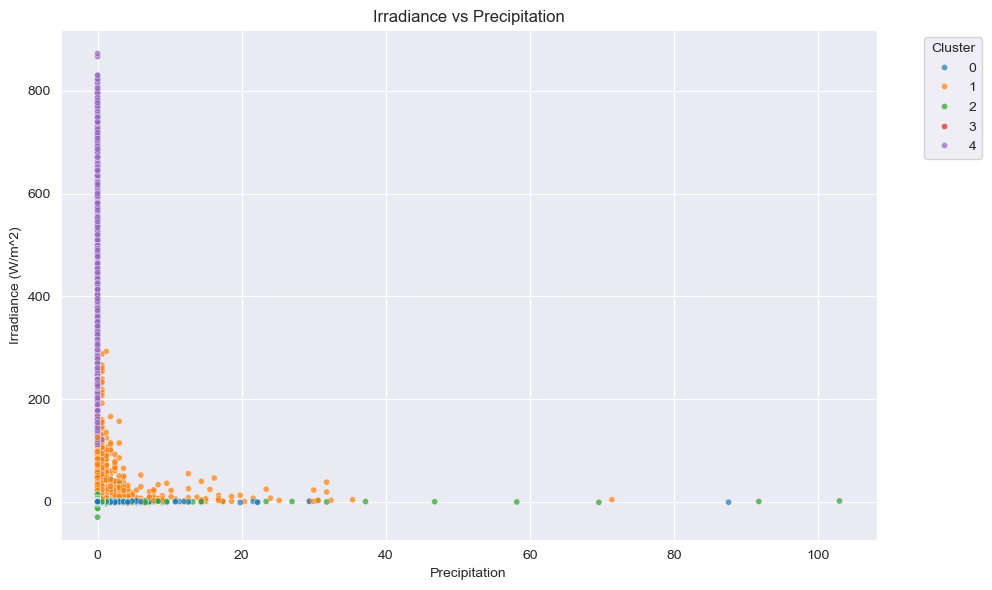

In [82]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=plot_df,
    x='Precipitation Avg',
    y='Broadband Irradiance',
    hue='Cluster',
    palette='tab10',   # or 'Set2', 'viridis', etc.
    s=20,              # size of points
    alpha=0.7          # transparency
)

plt.title("Irradiance vs Precipitation")
plt.xlabel("Precipitation")
plt.ylabel("Irradiance (W/m^2)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()